In [48]:
pip install iso639-lang

In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from iso639 import Lang
import pickle

In [50]:
#reading dataset
movies=pd.read_csv("/tmdb_5000_movies.csv")

In [51]:
#choosing only important features
data=movies[['id', 'genres', 'original_language', 'release_date', 'keywords', 'production_companies', 'popularity', 'vote_average', 'title']]

In [52]:
#checking and removing null values
print(data.isna().sum())
data.dropna(inplace=True)

id                      0
genres                  0
original_language       0
release_date            1
keywords                0
production_companies    0
popularity              0
vote_average            0
title                   0
dtype: int64


<ipython-input-52-11c674a7fd8c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [53]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
stopwords=stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [55]:
import string
puncts=list(string.punctuation)
print(puncts)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [88]:
#preprocessing genres, keywords, companies
def convert_to_text(data):
    processed=[]
    for dic in eval(data):
        name=dic['name'].lower().strip()
        processed.append(name)
    if len(processed)==0:
        processed.append('none')
    return processed

In [57]:
data['genres']=data['genres'].apply(convert_to_text)
#data

<ipython-input-57-56f9ab8972ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['genres']=data['genres'].apply(convert_to_text)


In [58]:
data['production_companies']=data['production_companies'].apply(convert_to_text)
#data

<ipython-input-58-2b9ba9584e50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['production_companies']=data['production_companies'].apply(convert_to_text)


In [89]:
def process_keywords(keywords):
    processed=[]
    for punc in puncts:
        if punc in keywords:
            keywords=keywords.replace(punc, '')
    words=keywords.split()
    for word in words:
        if not word in stopwords:
            processed.append(word)
    unique_words=pd.Series(processed).unique()
    return list(unique_words)

In [60]:
data["keywords"]=data["keywords"].apply(convert_to_text)
data["keywords"]=data["keywords"].apply(lambda value: process_keywords(' '.join(value)))
print(data["keywords"])

0       [culture, clash, future, space, war, space, co...
1       [ocean, drug, abuse, exotic, island, east, ind...
2       [spy, based, novel, secret, agent, sequel, mi6...
3       [dc, comics, crime, fighter, terrorist, secret...
4       [based, novel, mars, medallion, space, travel,...
                              ...                        
4798    [united, states–mexico, barrier, legs, arms, p...
4799                                               [none]
4800    [date, love, first, sight, narration, investig...
4801                                               [none]
4802           [obsession, camcorder, crush, dream, girl]
Name: keywords, Length: 4802, dtype: object


<ipython-input-60-236466f6bce1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["keywords"]=data["keywords"].apply(convert_to_text)
<ipython-input-60-236466f6bce1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["keywords"]=data["keywords"].apply(lambda value: process_keywords(' '.join(value)))


In [61]:
data['release_year']=data['release_date'].apply(lambda date: int(date.split('-')[0]))
data=data.loc[data['release_year']>1950] #release year outlier removal

<ipython-input-61-66adb20c80f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['release_year']=data['release_date'].apply(lambda date: int(date.split('-')[0]))


In [62]:
scaler=MinMaxScaler()
#data['popularity']=scaler.fit_transform(data[['popularity']])
data['vote_average']=scaler.fit_transform(data[['vote_average']])

<ipython-input-62-a2824771a47d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vote_average']=scaler.fit_transform(data[['vote_average']])


In [63]:
#preprocessing languages
data.loc[data["original_language"]=="cn", "original_language"]="zh"
lang_values=data.original_language.value_counts()
rare_lang=lang_values[lang_values<=5].index
print(rare_lang)
data.loc[data.original_language.isin(rare_lang), "original_language"]="other"

Index(['sv', 'fa', 'nl', 'he', 'th', 'ro', 'id', 'ar', 'cs', 'ta', 'tr', 'nb',
       'af', 'pl', 'is', 'hu', 'vi', 'ky', 'xx', 'te', 'no', 'sl', 'ps', 'el'],
      dtype='object', name='original_language')


In [ ]:
data["original_language"]=data["original_language"].apply(lambda lang_code: Lang(lang_code).name if lang_code!="other" else "other")
data

In [65]:
#like top companies, top keywords
def get_top_values(data_col):
 series=pd.Series()
 #companies, keywords for each movie
 for value in data_col:
  series=series._append(pd.Series(value))

 unique_values=series.value_counts()
 top_values=unique_values[unique_values>=5]
 return top_values.index

In [66]:
def process_top_values_list(values, top_values):
 inter=list(set(values) & set(top_values))
 if len(inter):
  return inter
 else:
  return ["others"]

In [67]:
top_companies=get_top_values(data["production_companies"])
data["production_companies"]=data["production_companies"].apply(lambda value: process_top_values_list(value, top_companies))

In [ ]:
#text extraction by encoding text data
genre_dummies=pd.get_dummies(data.genres.apply(pd.Series).stack(), prefix="genre").groupby(level=0).sum().drop("genre_none", axis=1)
genre_dummies

In [ ]:
language_dummies=pd.get_dummies(data.original_language, prefix="lang", dtype=int).drop("lang_other", axis=1)
language_dummies

In [ ]:
company_dummies=pd.get_dummies(data.production_companies.apply(pd.Series).stack(), prefix="company").groupby(level=0).sum().drop("company_none", axis=1)
company_dummies

In [71]:
movie_data=pd.concat([data.drop(["release_date"], axis=1), genre_dummies, language_dummies, company_dummies], axis=1)
xdata=movie_data.drop(["id", "title", "genres", "keywords", "original_language", "popularity", "production_companies"], axis=1)
print(xdata.columns)

Index(['genre_action', 'genre_adventure', 'genre_animation', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_foreign',
       ...
       'company_working title films', 'company_worldview entertainment',
       'company_wwe studios', 'company_x-filme creative pool',
       'company_yari film group', 'company_yash raj films',
       'company_zentropa entertainments', 'company_zide-perry productions',
       'vote_average', 'release_year'],
      dtype='object', length=495)


In [72]:
xdata

,genre_action,genre_adventure,genre_animation,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,genre_fantasy,genre_foreign,...,company_working title films,company_worldview entertainment,company_wwe studios,company_x-filme creative pool,company_yari film group,company_yash raj films,company_zentropa entertainments,company_zide-perry productions,vote_average,release_year
0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.72,2009
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.69,2007
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.63,2015
3,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.76,2012
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.61,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.66,1992
4799,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.59,2011
4800,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.70,2013
4801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.57,2012


In [73]:
#Elbow Method for finding no. of clusters
rng=[i for i in range(1,100)]
sse=[]
for k in rng:
 kmeans=KMeans(n_clusters=k, n_init='auto')
 kmeans.fit(xdata)
 sse.append(kmeans.inertia_)

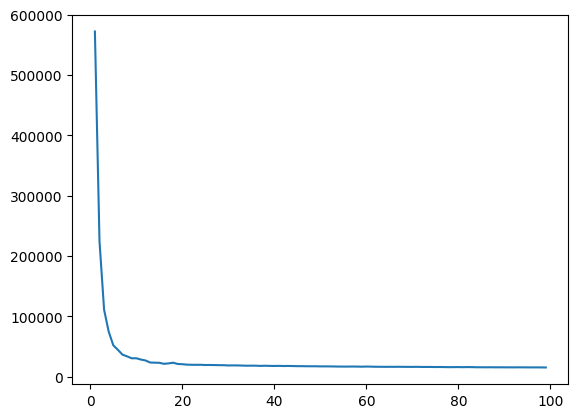

In [74]:
plt.plot(rng, sse)
plt.show()

In [75]:
#Training and testing
from sklearn.model_selection import train_test_split
xtrain, xtest=train_test_split(xdata, test_size=0.2)

In [76]:
pca=PCA(0.95)
x_train_pca=pca.fit_transform(xtrain)

In [77]:
model=KMeans(n_clusters=67, n_init='auto')
#movie_data['clusters']=model.fit_predict(x_train_pca)
model.fit(x_train_pca)

KMeans(n_clusters=67, n_init='auto')

In [78]:
x_test_pca=pca.transform(xtest)
test_clusters=model.predict(x_test_pca)

In [79]:
#Performance metrics in clustering
score=silhouette_score(x_test_pca, test_clusters)
print("score:", score)

score: 0.9879499245183864


In [80]:
model=KMeans(n_clusters=67, n_init='auto')

In [81]:
pca=PCA(0.95)
x_pca=pca.fit_transform(xdata)
movie_data['clusters']=model.fit_predict(x_pca)

In [ ]:
centroid=model.cluster_centers_
print("cluster centroids:", centroid)

In [83]:
#Saving pca model
with open("/pca_model.pickle", 'wb') as file:
 pickle.dump(pca, file)

In [84]:
#Saving clustered model
with open("/kmeans_model.pickle", 'wb') as file:
 pickle.dump(model, file)

#saving processed data
processed_data=movie_data.rename(columns={'genres': 'list_genres', 'production_companies': 'list_companies'})
processed_data.to_csv("/processed_data.csv", index=False)

In [85]:
def get_input_data(genres, lang, year, companies, vote_avg):
    cols=list(xdata.columns)
    data=np.zeros(len(cols))

    for genre in genres:
        if "genre_"+genre in cols:
            data[cols.index("genre_"+genre)]=1

    for company in companies:
        if "company_"+company in cols:
            data[cols.index("company_"+company)]=1

    if "lang_"+lang in cols:
        data[cols.index("lang_"+lang)]=True

    data[cols.index("release_year")]=year
    #data[cols.index("popularity")]=popularity
    data[cols.index("vote_average")]=vote_avg
    return pca.transform(data.reshape(1,-1))

In [86]:
def recommend_movies(genre=[], lang='en', year=2010, company=[], vote_avg=1, num=10):
    data=get_input_data(genre, lang, year, company, vote_avg)
    cluster=model.predict(data)[0]
    cluster_movies=movie_data[movie_data.clusters==cluster]
    recommended=cluster_movies.sort_values(by="popularity", ascending=False)
    recommended=recommended.head(num)[['id', 'title', 'release_year']]
    recommended.index=range(0, num)
    return recommended

In [87]:
if __name__=="__main__":
    recommendations=recommend_movies()
    print(recommendations)

      id                       title  release_year
0  27205                   Inception          2010
1  20352               Despicable Me          2010
2  24021  The Twilight Saga: Eclipse          2010
3  44214                  Black Swan          2010
4  11324              Shutter Island          2010
5  12155         Alice in Wonderland          2010
6  27578             The Expendables          2010
7  10138                  Iron Man 2          2010
8  20526                TRON: Legacy          2010
9  37799          The Social Network          2010


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
